# 基于DDPG算法的电磁式阻尼器控制

本笔记本实现了基于DDPG算法的二自由度电磁阻尼器控制系统。参数来源于MATLAB仿真文件，方法迁移自《数据驱动的动力学系统建模及控制策略研究》。

### 导入外部依赖

In [1]:
import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import logging
# from pathlib import Path
# 设置随机种子，保证结果可重现
# import random
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

### 编程环境搭建

In [2]:
train_model = True  # 训练模式开关

from env import ElectromagneticDamperEnv # 自定义环境
from ddpg_agent import DDPGAgent, ReplayBuffer # DDPG智能体和经验回放缓冲区
from train import train_ddpg # 训练函数
from af import plot_rewards, plot_state_comparison, plot_data, plot_test_data # 绘图函数
from af import load_checkpoint # 加载检查点函数
from rewardfx import select_dimensions

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei', 'Arial']

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建保存模型的基础目录
base_dir = "./savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认训练保存目录
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

project_name = input("请输入加载/创建项目的名称 (父目录: ./savedata) ").strip()

save_dir = os.path.join(base_dir, project_name)
is_new_project = not os.path.exists(save_dir)
os.makedirs(save_dir, exist_ok=True)
save_checkpoint_path = os.path.join(save_dir, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)
save_plot_path = os.path.join(save_dir, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = save_dir + f'\\training_log_{current_time}.log'
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = save_dir + f'\\training_log_{current_time}.log'

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", save_dir)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)

使用设备: cuda


## 超参数设置

In [3]:
# 仿真环境设置
T = 5
Ts = 0.002
tolerance = 1e-5 # 误差容忍度
# DDPG智能体设置
hidden_dim=64 # 隐藏层维度
action_bound=5.0 # 动作范围
actor_lr=1e-4 # Actor学习率
critic_lr=1e-3 # Critic学习率
gamma=0.98 # 折扣因子
tau=5e-3 # 软更新参数
sigma=0.02 # 初始噪声标准差
clip_grad=True # 是否裁剪梯度
# 经验池设置
capacity= int(1e6) # 经验池容量
batch_size=64 # 批量大小
# 训练超参数
n_episodes = 400 # 训练轮数
min_buffer_size = int(1e4) # 最小经验池大小
print_interval = 5 # 打印间隔
save_interval = 5 # 保存间隔

### 系统参数设置

从MATLAB仿真文件中提取二自由度电磁阻尼器系统的参数。

In [4]:
# 系统参数（来自MATLAB文件）
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000.0  # 电磁吸振器刚度
k_M = 200000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 0.2  # 电磁吸振器阻尼
c_M = 1.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.zeros((2, 1))

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

### 无控制输出环境验证

仿真进度:   0%|          | 0/10000 [00:00<?, ?it/s]

仿真进度: 10001it [00:00, 17450.83it/s]                          


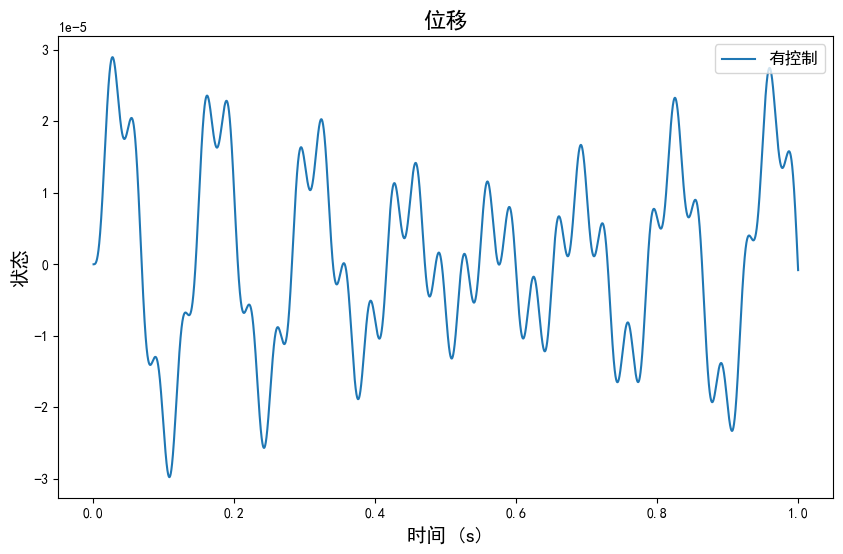

In [ ]:
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=0.0001, T=1)

# 定义正弦扰动函数用于测试
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(2 * np.pi * freq * t)
    return func

from rewardfx import tolerance_liner_rf, tolerance_exp_rf
rl_env.set_reward_function(tolerance_exp_rf(tolerance=tolerance))

# 运行无控制的仿真
results_no_control = rl_env.run_simulation(z_func=sine_disturbance(0.0001, 30))

plot_test_data(save_plot_path=save_plot_path, data = results_no_control)

## 训练DDPG代理

### 初始化环境和DDPG代理

In [ ]:
# 观测状态列表
# 0: 吸振器位移 (x1)
# 1: 吸振器速度 (v1)
# 2: 吸振器加速度 (a1)
# 3: 平台位移 (x2)
# 4: 平台速度 (v2)
# 5: 平台加速度 (a2)

observation_indices = [0,2,3,5]  # 观测状态索引

# 定义正弦扰动函数
def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(2 * np.pi * freq * t)
    return func
z_func=sine_disturbance(0.001, 30)

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))

# 定义奖励函数
from rewardfx import tolerance_liner_rf, tolerance_exp_rf
r_func = tolerance_exp_rf(tolerance=tolerance)

if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))

# 创建仿真环境
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=Ts, T=T, z_func=z_func, obs_indices=observation_indices,r_func=r_func)
rl_env.set_observation_indices(observation_indices) # 设置观测状态索引

# 创建DDPG智能体
agent = DDPGAgent(
    state_dim = len(observation_indices), # 状态维度
    hidden_dim=hidden_dim, # 隐藏层维度
    action_bound=action_bound, # 动作范围
    actor_lr=actor_lr, # Actor学习率
    critic_lr=critic_lr, # Critic学习率
    gamma=gamma, # 折扣因子
    tau=tau, # 软更新参数
    sigma=sigma, # 初始噪声标准差
    clip_grad=clip_grad, # 是否裁剪梯度
)

# 创建经验回放池
replay_buffer = ReplayBuffer(capacity=capacity, batch_size=batch_size)

### 记录日志

In [ ]:
if train_model:
    logging.info(f"开始训练的时间: {datetime.now()}")  # 记录训练开始时间
    paras_info = {
        "仿真时间": T,
        "采样时间": Ts,
        "误差容忍度": tolerance,
        "隐藏层维度": hidden_dim,
        "动作范围": action_bound,
        "Actor学习率": actor_lr,
        "Critic学习率": critic_lr,
        "折扣因子": gamma,
        "软更新参数": tau,
        "是否梯度裁剪": clip_grad,
        "初始噪声标准差": sigma,
        "经验池容量": capacity,
        "批量大小": batch_size,
        "训练轮数": n_episodes,
        "最小经验池大小": min_buffer_size,
        "打印间隔": print_interval,
        "保存间隔": save_interval
    }
    logging.info(f"训练参数：{json.dumps(paras_info, indent=4, ensure_ascii=False)}")  # 记录训练参数
    
    logging.info(f"Actor网络架构:{agent.actor}")  # 记录Actor网络架构
    logging.info(f"Critic网络架构:{agent.critic}")  # 记录Critic网络架构
    
    start_episode,initial_episode_rewards = load_checkpoint(agent=agent, save_dir=os.path.join(save_dir, f"checkpoints")) # 加载检查点

    logging.info(f"开始训练的轮数: {start_episode}")

### 训练DDPG代理

In [ ]:
if train_model:# 训练DDPG代理
    try:
        training_results = train_ddpg(
            env=rl_env,
            agent=agent,
            replay_buffer=replay_buffer,
            n_episodes=n_episodes, # 训练轮数
            min_buffer_size=min_buffer_size, # 最小经验池大小
            print_interval=print_interval, # 打印间隔
            save_interval=save_interval, # 保存间隔
            save_path=save_checkpoint_path, # 保存训练信息的路径
            start_episode=start_episode,
            initial_episode_rewards=initial_episode_rewards,
        )
    except KeyboardInterrupt:
        logging.info("训练中断，保存当前模型...")
        agent.save_model(save_path=save_checkpoint_path, episode=n_episodes)
        logging.info("模型已保存。")
    except Exception as e:
        logging.error(f"训练过程中发生错误: {e}")
        raise e

    logging.info(f"训练完成，最终平均奖励: {training_results['avg_rewards'][-1]:.2f}")

仿真进度: 2501it [00:00, 14413.63it/s]                          
训练轮次:   1%|          | 4/400 [00:08<14:02,  2.13s/it]

Episode:    5, Reward: -2498.68, Avg Reward: -2495.94, Avg Critic Loss: 0.0518, Avg Actor Loss: 1.3987, Epsilon: 0.98


仿真进度: 2501it [00:02, 1021.28it/s]                          
训练轮次:   1%|▏         | 5/400 [00:40<1:24:32, 12.84s/it]

已保存模型数据: 0520_2207_ep5_checkpoint.pth


训练轮次:   2%|▏         | 9/400 [02:40<3:02:10, 27.95s/it]

Episode:   10, Reward: -2497.09, Avg Reward: -2494.10, Avg Critic Loss: 0.9547, Avg Actor Loss: 31.4926, Epsilon: 0.96


仿真进度: 2501it [00:02, 1105.69it/s]                          
训练轮次:   2%|▎         | 10/400 [03:21<3:28:13, 32.03s/it]

已保存模型数据: 0520_2207_ep10_checkpoint.pth


训练轮次:   4%|▎         | 14/400 [05:09<2:58:34, 27.76s/it]

Episode:   15, Reward: -2496.54, Avg Reward: -2493.86, Avg Critic Loss: 0.6499, Avg Actor Loss: 42.0774, Epsilon: 0.94


仿真进度: 2501it [00:01, 1306.72it/s]                          
训练轮次:   4%|▍         | 15/400 [05:35<2:54:40, 27.22s/it]

已保存模型数据: 0520_2207_ep15_checkpoint.pth


训练轮次:   5%|▍         | 19/400 [07:10<2:35:22, 24.47s/it]

Episode:   20, Reward: -2496.55, Avg Reward: -2493.38, Avg Critic Loss: 0.8964, Avg Actor Loss: 47.3170, Epsilon: 0.92


仿真进度: 2501it [00:01, 1327.40it/s]                          
训练轮次:   5%|▌         | 20/400 [07:36<2:37:44, 24.91s/it]

已保存模型数据: 0520_2207_ep20_checkpoint.pth


训练轮次:   6%|▌         | 24/400 [09:12<2:32:58, 24.41s/it]

Episode:   25, Reward: -2494.29, Avg Reward: -2493.10, Avg Critic Loss: 0.9134, Avg Actor Loss: 48.9086, Epsilon: 0.90


仿真进度: 2501it [00:02, 1198.62it/s]
训练轮次:   6%|▋         | 25/400 [09:40<2:39:50, 25.57s/it]

已保存模型数据: 0520_2207_ep25_checkpoint.pth


训练轮次:   7%|▋         | 29/400 [11:19<2:33:03, 24.75s/it]

Episode:   30, Reward: -2492.23, Avg Reward: -2493.12, Avg Critic Loss: 0.8826, Avg Actor Loss: 49.4297, Epsilon: 0.88


仿真进度: 2501it [00:02, 1182.94it/s]                          
训练轮次:   8%|▊         | 30/400 [11:45<2:35:38, 25.24s/it]

已保存模型数据: 0520_2207_ep30_checkpoint.pth


训练轮次:   8%|▊         | 34/400 [13:23<2:30:29, 24.67s/it]

Episode:   35, Reward: -2492.37, Avg Reward: -2493.14, Avg Critic Loss: 0.8637, Avg Actor Loss: 49.6348, Epsilon: 0.86


仿真进度: 2501it [00:01, 1281.65it/s]                          
训练轮次:   9%|▉         | 35/400 [13:51<2:34:39, 25.42s/it]

已保存模型数据: 0520_2207_ep35_checkpoint.pth


训练轮次:  10%|▉         | 39/400 [15:35<2:38:28, 26.34s/it]

Episode:   40, Reward: -2491.73, Avg Reward: -2492.90, Avg Critic Loss: 0.8589, Avg Actor Loss: 49.6927, Epsilon: 0.84


仿真进度: 2501it [00:01, 1616.77it/s]                          
训练轮次:  10%|█         | 40/400 [16:04<2:41:40, 26.95s/it]

已保存模型数据: 0520_2207_ep40_checkpoint.pth


训练轮次:  11%|█         | 44/400 [17:46<2:35:34, 26.22s/it]

Episode:   45, Reward: -2494.09, Avg Reward: -2492.79, Avg Critic Loss: 0.9659, Avg Actor Loss: 49.7248, Epsilon: 0.82


仿真进度: 2501it [00:02, 1208.23it/s]                          
训练轮次:  11%|█▏        | 45/400 [18:14<2:38:24, 26.77s/it]

已保存模型数据: 0520_2207_ep45_checkpoint.pth


训练轮次:  12%|█▏        | 49/400 [19:57<2:30:48, 25.78s/it]

Episode:   50, Reward: -2489.18, Avg Reward: -2492.57, Avg Critic Loss: 1.0214, Avg Actor Loss: 49.7269, Epsilon: 0.80


仿真进度: 2501it [00:03, 784.43it/s]                          
训练轮次:  12%|█▎        | 50/400 [20:35<2:52:20, 29.54s/it]

已保存模型数据: 0520_2207_ep50_checkpoint.pth


训练轮次:  14%|█▎        | 54/400 [22:20<2:34:57, 26.87s/it]

Episode:   55, Reward: -2492.98, Avg Reward: -2492.50, Avg Critic Loss: 0.9758, Avg Actor Loss: 49.7363, Epsilon: 0.78


仿真进度: 2501it [00:02, 1205.44it/s]                          
训练轮次:  14%|█▍        | 55/400 [22:50<2:40:28, 27.91s/it]

已保存模型数据: 0520_2207_ep55_checkpoint.pth


训练轮次:  15%|█▍        | 59/400 [24:37<2:31:47, 26.71s/it]

Episode:   60, Reward: -2487.92, Avg Reward: -2492.35, Avg Critic Loss: 0.8257, Avg Actor Loss: 49.7479, Epsilon: 0.75


仿真进度: 2501it [00:01, 1370.15it/s]                          
训练轮次:  15%|█▌        | 60/400 [25:05<2:33:58, 27.17s/it]

已保存模型数据: 0520_2207_ep60_checkpoint.pth


训练轮次:  16%|█▌        | 64/400 [27:14<3:05:49, 33.18s/it]

Episode:   65, Reward: -2495.54, Avg Reward: -2492.37, Avg Critic Loss: 1.0935, Avg Actor Loss: 49.7559, Epsilon: 0.73


仿真进度: 2501it [00:03, 771.23it/s]                          
训练轮次:  16%|█▋        | 65/400 [27:59<3:25:25, 36.79s/it]

已保存模型数据: 0520_2207_ep65_checkpoint.pth


训练轮次:  17%|█▋        | 69/400 [30:15<2:59:14, 32.49s/it]

Episode:   70, Reward: -2491.54, Avg Reward: -2492.29, Avg Critic Loss: 0.9877, Avg Actor Loss: 49.7400, Epsilon: 0.71


仿真进度: 2501it [00:01, 1362.38it/s]                          
训练轮次:  18%|█▊        | 70/400 [30:43<2:51:10, 31.12s/it]

已保存模型数据: 0520_2207_ep70_checkpoint.pth


训练轮次:  18%|█▊        | 74/400 [32:24<2:25:01, 26.69s/it]

Episode:   75, Reward: -2490.40, Avg Reward: -2492.34, Avg Critic Loss: 1.2115, Avg Actor Loss: 49.7734, Epsilon: 0.69


仿真进度: 2501it [00:01, 1368.04it/s]                          
训练轮次:  19%|█▉        | 75/400 [32:52<2:26:51, 27.11s/it]

已保存模型数据: 0520_2207_ep75_checkpoint.pth


训练轮次:  20%|█▉        | 79/400 [34:39<2:20:40, 26.29s/it]

Episode:   80, Reward: -2490.64, Avg Reward: -2492.43, Avg Critic Loss: 0.8993, Avg Actor Loss: 49.7718, Epsilon: 0.67


仿真进度: 2501it [00:01, 1361.45it/s]                          
训练轮次:  20%|██        | 80/400 [35:06<2:21:27, 26.52s/it]

已保存模型数据: 0520_2207_ep80_checkpoint.pth


训练轮次:  21%|██        | 84/400 [36:47<2:13:41, 25.38s/it]

Episode:   85, Reward: -2485.95, Avg Reward: -2492.41, Avg Critic Loss: 1.1099, Avg Actor Loss: 49.7783, Epsilon: 0.65


仿真进度: 2501it [00:01, 1443.83it/s]                          
训练轮次:  21%|██▏       | 85/400 [37:15<2:17:23, 26.17s/it]

已保存模型数据: 0520_2207_ep85_checkpoint.pth


训练轮次:  22%|██▏       | 89/400 [38:59<2:16:41, 26.37s/it]

Episode:   90, Reward: -2488.31, Avg Reward: -2492.47, Avg Critic Loss: 1.0501, Avg Actor Loss: 49.7795, Epsilon: 0.63


仿真进度: 2501it [00:01, 1346.34it/s]                          
训练轮次:  22%|██▎       | 90/400 [39:27<2:19:17, 26.96s/it]

已保存模型数据: 0520_2207_ep90_checkpoint.pth


训练轮次:  24%|██▎       | 94/400 [41:19<2:22:57, 28.03s/it]

Episode:   95, Reward: -2496.02, Avg Reward: -2492.46, Avg Critic Loss: 1.0345, Avg Actor Loss: 49.8011, Epsilon: 0.61


仿真进度: 2501it [00:01, 1592.47it/s]                          
训练轮次:  24%|██▍       | 95/400 [41:55<2:34:00, 30.30s/it]

已保存模型数据: 0520_2207_ep95_checkpoint.pth


训练轮次:  25%|██▍       | 99/400 [43:44<2:21:20, 28.17s/it]

Episode:  100, Reward: -2492.33, Avg Reward: -2492.48, Avg Critic Loss: 1.0356, Avg Actor Loss: 49.8227, Epsilon: 0.59


仿真进度: 2501it [00:01, 1525.49it/s]                          
训练轮次:  25%|██▌       | 100/400 [44:13<2:20:54, 28.18s/it]

已保存模型数据: 0520_2207_ep100_checkpoint.pth


训练轮次:  26%|██▌       | 104/400 [46:02<2:16:28, 27.66s/it]

Episode:  105, Reward: -2485.97, Avg Reward: -2492.28, Avg Critic Loss: 1.0388, Avg Actor Loss: 49.8139, Epsilon: 0.57


仿真进度: 2501it [00:02, 1078.03it/s]                          
训练轮次:  26%|██▋       | 105/400 [46:32<2:20:14, 28.52s/it]

已保存模型数据: 0520_2207_ep105_checkpoint.pth


训练轮次:  27%|██▋       | 109/400 [48:23<2:15:45, 27.99s/it]

Episode:  110, Reward: -2497.70, Avg Reward: -2492.36, Avg Critic Loss: 1.0202, Avg Actor Loss: 49.8189, Epsilon: 0.55


仿真进度: 2501it [00:01, 1265.20it/s]                          
训练轮次:  28%|██▊       | 110/400 [48:54<2:18:26, 28.64s/it]

已保存模型数据: 0520_2207_ep110_checkpoint.pth


训练轮次:  28%|██▊       | 114/400 [51:12<2:42:10, 34.02s/it]

Episode:  115, Reward: -2486.60, Avg Reward: -2492.31, Avg Critic Loss: 0.6910, Avg Actor Loss: 49.8210, Epsilon: 0.53


仿真进度: 2501it [00:01, 1251.64it/s]                          
训练轮次:  29%|██▉       | 115/400 [51:55<2:54:25, 36.72s/it]

已保存模型数据: 0520_2207_ep115_checkpoint.pth


训练轮次:  30%|██▉       | 119/400 [54:04<2:38:14, 33.79s/it]

Episode:  120, Reward: -2491.33, Avg Reward: -2492.30, Avg Critic Loss: 0.9327, Avg Actor Loss: 49.7781, Epsilon: 0.50


仿真进度: 2501it [00:02, 998.52it/s]                           
训练轮次:  30%|███       | 120/400 [54:43<2:45:15, 35.41s/it]

已保存模型数据: 0520_2207_ep120_checkpoint.pth


训练轮次:  31%|███       | 124/400 [57:02<2:42:51, 35.40s/it]

Episode:  125, Reward: -2493.78, Avg Reward: -2492.30, Avg Critic Loss: 1.0032, Avg Actor Loss: 49.7840, Epsilon: 0.48


仿真进度: 2501it [00:02, 902.44it/s]                          
训练轮次:  31%|███▏      | 125/400 [57:39<2:44:58, 35.99s/it]

已保存模型数据: 0520_2207_ep125_checkpoint.pth


训练轮次:  32%|███▏      | 129/400 [59:53<2:32:12, 33.70s/it]

Episode:  130, Reward: -2496.33, Avg Reward: -2492.37, Avg Critic Loss: 0.8716, Avg Actor Loss: 49.7833, Epsilon: 0.46


仿真进度: 2501it [00:02, 1212.39it/s]                          
训练轮次:  32%|███▎      | 130/400 [1:00:26<2:31:01, 33.56s/it]

已保存模型数据: 0520_2207_ep130_checkpoint.pth


训练轮次:  34%|███▎      | 134/400 [1:02:32<2:23:33, 32.38s/it]

Episode:  135, Reward: -2495.25, Avg Reward: -2492.44, Avg Critic Loss: 0.9455, Avg Actor Loss: 49.8109, Epsilon: 0.44


仿真进度: 2501it [00:02, 1119.97it/s]                          
训练轮次:  34%|███▍      | 135/400 [1:03:10<2:31:22, 34.27s/it]

已保存模型数据: 0520_2207_ep135_checkpoint.pth


训练轮次:  35%|███▍      | 139/400 [1:05:20<2:21:48, 32.60s/it]

Episode:  140, Reward: -2493.44, Avg Reward: -2492.21, Avg Critic Loss: 1.0482, Avg Actor Loss: 49.8007, Epsilon: 0.42


仿真进度: 2501it [00:01, 1334.91it/s]                          
训练轮次:  35%|███▌      | 140/400 [1:05:53<2:21:33, 32.67s/it]

已保存模型数据: 0520_2207_ep140_checkpoint.pth


训练轮次:  36%|███▌      | 144/400 [1:07:41<2:01:26, 28.46s/it]

Episode:  145, Reward: -2492.77, Avg Reward: -2492.18, Avg Critic Loss: 1.0195, Avg Actor Loss: 49.8106, Epsilon: 0.40


仿真进度: 2501it [00:01, 1256.94it/s]                          
训练轮次:  36%|███▋      | 145/400 [1:08:11<2:02:01, 28.71s/it]

已保存模型数据: 0520_2207_ep145_checkpoint.pth


训练轮次:  37%|███▋      | 149/400 [1:09:59<1:55:00, 27.49s/it]

Episode:  150, Reward: -2487.77, Avg Reward: -2492.06, Avg Critic Loss: 0.9899, Avg Actor Loss: 49.8008, Epsilon: 0.38


仿真进度: 2501it [00:01, 1407.12it/s]                          
训练轮次:  38%|███▊      | 150/400 [1:10:28<1:56:46, 28.02s/it]

已保存模型数据: 0520_2207_ep150_checkpoint.pth


训练轮次:  38%|███▊      | 154/400 [1:12:17<1:52:16, 27.38s/it]

Episode:  155, Reward: -2493.04, Avg Reward: -2491.81, Avg Critic Loss: 0.9891, Avg Actor Loss: 49.7935, Epsilon: 0.36


仿真进度: 2501it [00:01, 1506.32it/s]                          
训练轮次:  39%|███▉      | 155/400 [1:12:47<1:54:32, 28.05s/it]

已保存模型数据: 0520_2207_ep155_checkpoint.pth


训练轮次:  40%|███▉      | 159/400 [1:14:37<1:51:18, 27.71s/it]

Episode:  160, Reward: -2491.00, Avg Reward: -2491.85, Avg Critic Loss: 0.9140, Avg Actor Loss: 49.7820, Epsilon: 0.34


仿真进度: 2501it [00:01, 1422.31it/s]                          
训练轮次:  40%|████      | 160/400 [1:15:07<1:53:50, 28.46s/it]

已保存模型数据: 0520_2207_ep160_checkpoint.pth


训练轮次:  41%|████      | 164/400 [1:17:01<1:52:07, 28.51s/it]

Episode:  165, Reward: -2494.62, Avg Reward: -2491.79, Avg Critic Loss: 1.2273, Avg Actor Loss: 49.7853, Epsilon: 0.32


仿真进度: 2501it [00:01, 1442.84it/s]                          
训练轮次:  41%|████▏     | 165/400 [1:17:32<1:54:04, 29.12s/it]

已保存模型数据: 0520_2207_ep165_checkpoint.pth


训练轮次:  42%|████▏     | 169/400 [1:19:25<1:50:17, 28.65s/it]

Episode:  170, Reward: -2492.55, Avg Reward: -2491.82, Avg Critic Loss: 0.9436, Avg Actor Loss: 49.7765, Epsilon: 0.30


仿真进度: 2501it [00:01, 1282.21it/s]                          
训练轮次:  42%|████▎     | 170/400 [1:19:56<1:52:48, 29.43s/it]

已保存模型数据: 0520_2207_ep170_checkpoint.pth


训练轮次:  44%|████▎     | 174/400 [1:21:52<1:49:25, 29.05s/it]

Episode:  175, Reward: -2485.31, Avg Reward: -2491.67, Avg Critic Loss: 0.8996, Avg Actor Loss: 49.7940, Epsilon: 0.28


仿真进度: 2501it [00:01, 1267.53it/s]                          
训练轮次:  44%|████▍     | 175/400 [1:22:23<1:51:20, 29.69s/it]

已保存模型数据: 0520_2207_ep175_checkpoint.pth


训练轮次:  45%|████▍     | 179/400 [1:24:19<1:47:10, 29.10s/it]

Episode:  180, Reward: -2496.20, Avg Reward: -2491.59, Avg Critic Loss: 0.8713, Avg Actor Loss: 49.8122, Epsilon: 0.25


仿真进度: 2501it [00:01, 1282.89it/s]                          
训练轮次:  45%|████▌     | 180/400 [1:24:50<1:49:14, 29.79s/it]

已保存模型数据: 0520_2207_ep180_checkpoint.pth


训练轮次:  46%|████▌     | 184/400 [1:26:47<1:45:22, 29.27s/it]

Episode:  185, Reward: -2491.34, Avg Reward: -2491.57, Avg Critic Loss: 1.0790, Avg Actor Loss: 49.8052, Epsilon: 0.23


仿真进度: 2501it [00:01, 1295.88it/s]                          
训练轮次:  46%|████▋     | 185/400 [1:27:18<1:47:13, 29.92s/it]

已保存模型数据: 0520_2207_ep185_checkpoint.pth


训练轮次:  47%|████▋     | 189/400 [1:29:17<1:45:10, 29.91s/it]

Episode:  190, Reward: -2491.32, Avg Reward: -2491.45, Avg Critic Loss: 1.0525, Avg Actor Loss: 49.7963, Epsilon: 0.21


仿真进度: 2501it [00:02, 1111.95it/s]                          
训练轮次:  48%|████▊     | 190/400 [1:29:51<1:49:18, 31.23s/it]

已保存模型数据: 0520_2207_ep190_checkpoint.pth


训练轮次:  48%|████▊     | 194/400 [1:32:06<1:53:31, 33.07s/it]

Episode:  195, Reward: -2490.06, Avg Reward: -2491.39, Avg Critic Loss: 0.8544, Avg Actor Loss: 49.7883, Epsilon: 0.19


仿真进度: 2501it [00:01, 1316.97it/s]                          
训练轮次:  49%|████▉     | 195/400 [1:32:42<1:56:17, 34.04s/it]

已保存模型数据: 0520_2207_ep195_checkpoint.pth


训练轮次:  50%|████▉     | 199/400 [1:34:48<1:47:42, 32.15s/it]

Episode:  200, Reward: -2497.79, Avg Reward: -2491.38, Avg Critic Loss: 1.0043, Avg Actor Loss: 49.7880, Epsilon: 0.17


仿真进度: 2501it [00:02, 1239.40it/s]                          
训练轮次:  50%|█████     | 200/400 [1:35:23<1:49:33, 32.87s/it]

已保存模型数据: 0520_2207_ep200_checkpoint.pth


训练轮次:  51%|█████     | 204/400 [1:37:30<1:44:54, 32.11s/it]

Episode:  205, Reward: -2497.04, Avg Reward: -2491.57, Avg Critic Loss: 0.9898, Avg Actor Loss: 49.8093, Epsilon: 0.15


仿真进度: 2501it [00:02, 1069.92it/s]                          
训练轮次:  51%|█████▏    | 205/400 [1:38:05<1:46:58, 32.92s/it]

已保存模型数据: 0520_2207_ep205_checkpoint.pth


训练轮次:  52%|█████▏    | 209/400 [1:40:08<1:38:37, 30.98s/it]

Episode:  210, Reward: -2493.75, Avg Reward: -2491.61, Avg Critic Loss: 1.0186, Avg Actor Loss: 49.8147, Epsilon: 0.13


仿真进度: 2501it [00:02, 1216.29it/s]                          
训练轮次:  52%|█████▎    | 210/400 [1:40:40<1:39:45, 31.50s/it]

已保存模型数据: 0520_2207_ep210_checkpoint.pth


训练轮次:  54%|█████▎    | 214/400 [1:42:41<1:34:31, 30.49s/it]

Episode:  215, Reward: -2496.22, Avg Reward: -2491.82, Avg Critic Loss: 0.9890, Avg Actor Loss: 49.7788, Epsilon: 0.11


仿真进度: 2501it [00:01, 1270.74it/s]                          
训练轮次:  54%|█████▍    | 215/400 [1:43:13<1:36:02, 31.15s/it]

已保存模型数据: 0520_2207_ep215_checkpoint.pth


训练轮次:  55%|█████▍    | 219/400 [1:45:16<1:32:46, 30.76s/it]

Episode:  220, Reward: -2497.54, Avg Reward: -2492.07, Avg Critic Loss: 1.1233, Avg Actor Loss: 49.7685, Epsilon: 0.10


仿真进度: 2501it [00:01, 1262.54it/s]                          
训练轮次:  55%|█████▌    | 220/400 [1:45:49<1:34:32, 31.51s/it]

已保存模型数据: 0520_2207_ep220_checkpoint.pth


训练轮次:  56%|█████▌    | 224/400 [1:47:52<1:30:33, 30.87s/it]

Episode:  225, Reward: -2497.48, Avg Reward: -2492.35, Avg Critic Loss: 0.8686, Avg Actor Loss: 49.7843, Epsilon: 0.10


仿真进度: 2501it [00:01, 1314.69it/s]                          
训练轮次:  56%|█████▋    | 225/400 [1:48:25<1:31:39, 31.43s/it]

已保存模型数据: 0520_2207_ep225_checkpoint.pth


训练轮次:  57%|█████▋    | 229/400 [1:50:28<1:28:17, 30.98s/it]

Episode:  230, Reward: -2496.92, Avg Reward: -2492.48, Avg Critic Loss: 0.8713, Avg Actor Loss: 49.7848, Epsilon: 0.10


仿真进度: 2501it [00:01, 1340.53it/s]                          
训练轮次:  57%|█████▊    | 230/400 [1:51:01<1:29:35, 31.62s/it]

已保存模型数据: 0520_2207_ep230_checkpoint.pth


训练轮次:  58%|█████▊    | 234/400 [1:53:05<1:25:59, 31.08s/it]

Episode:  235, Reward: -2494.83, Avg Reward: -2492.53, Avg Critic Loss: 0.9923, Avg Actor Loss: 49.7774, Epsilon: 0.10


仿真进度: 2501it [00:01, 1383.42it/s]                          
训练轮次:  59%|█████▉    | 235/400 [1:53:38<1:27:01, 31.65s/it]

已保存模型数据: 0520_2207_ep235_checkpoint.pth


训练轮次:  60%|█████▉    | 239/400 [1:55:41<1:23:22, 31.07s/it]

Episode:  240, Reward: -2498.26, Avg Reward: -2492.99, Avg Critic Loss: 0.9433, Avg Actor Loss: 49.7809, Epsilon: 0.10


仿真进度: 2501it [00:01, 1279.29it/s]                          
训练轮次:  60%|██████    | 240/400 [1:56:14<1:24:37, 31.74s/it]

已保存模型数据: 0520_2207_ep240_checkpoint.pth


训练轮次:  61%|██████    | 244/400 [1:58:19<1:21:14, 31.24s/it]

Episode:  245, Reward: -2492.14, Avg Reward: -2493.09, Avg Critic Loss: 0.9320, Avg Actor Loss: 49.7862, Epsilon: 0.10


仿真进度: 2501it [00:01, 1420.21it/s]                          
训练轮次:  61%|██████▏   | 245/400 [1:58:52<1:22:30, 31.94s/it]

已保存模型数据: 0520_2207_ep245_checkpoint.pth


训练轮次:  62%|██████▏   | 249/400 [2:00:58<1:19:20, 31.53s/it]

Episode:  250, Reward: -2494.21, Avg Reward: -2493.42, Avg Critic Loss: 1.1535, Avg Actor Loss: 49.7892, Epsilon: 0.10


仿真进度: 2501it [00:01, 1326.79it/s]                          
训练轮次:  62%|██████▎   | 250/400 [2:01:31<1:20:13, 32.09s/it]

已保存模型数据: 0520_2207_ep250_checkpoint.pth


训练轮次:  64%|██████▎   | 254/400 [2:03:37<1:16:40, 31.51s/it]

Episode:  255, Reward: -2493.09, Avg Reward: -2493.77, Avg Critic Loss: 0.7207, Avg Actor Loss: 49.8042, Epsilon: 0.10


仿真进度: 2501it [00:01, 1269.87it/s]                          
训练轮次:  64%|██████▍   | 255/400 [2:04:10<1:17:45, 32.18s/it]

已保存模型数据: 0520_2207_ep255_checkpoint.pth


训练轮次:  65%|██████▍   | 259/400 [2:06:17<1:14:50, 31.84s/it]

Episode:  260, Reward: -2492.39, Avg Reward: -2493.89, Avg Critic Loss: 1.0359, Avg Actor Loss: 49.8131, Epsilon: 0.10


仿真进度: 2501it [00:01, 1291.25it/s]                          
训练轮次:  65%|██████▌   | 260/400 [2:06:51<1:15:54, 32.54s/it]

已保存模型数据: 0520_2207_ep260_checkpoint.pth


训练轮次:  66%|██████▌   | 264/400 [2:08:59<1:12:34, 32.02s/it]

Episode:  265, Reward: -2497.55, Avg Reward: -2494.09, Avg Critic Loss: 1.0096, Avg Actor Loss: 49.8204, Epsilon: 0.10


仿真进度: 2501it [00:01, 1311.92it/s]                          
训练轮次:  66%|██████▋   | 265/400 [2:09:33<1:13:38, 32.73s/it]

已保存模型数据: 0520_2207_ep265_checkpoint.pth


训练轮次:  67%|██████▋   | 269/400 [2:11:42<1:10:26, 32.27s/it]

Episode:  270, Reward: -2496.20, Avg Reward: -2494.34, Avg Critic Loss: 1.0860, Avg Actor Loss: 49.8154, Epsilon: 0.10


仿真进度: 2501it [00:02, 933.82it/s]                          
训练轮次:  68%|██████▊   | 270/400 [2:12:18<1:12:34, 33.50s/it]

已保存模型数据: 0520_2207_ep270_checkpoint.pth


训练轮次:  68%|██████▊   | 274/400 [2:14:28<1:07:34, 32.18s/it]

Episode:  275, Reward: -2491.78, Avg Reward: -2494.55, Avg Critic Loss: 1.0185, Avg Actor Loss: 49.8073, Epsilon: 0.10


仿真进度: 2501it [00:02, 1248.58it/s]                          
训练轮次:  69%|██████▉   | 275/400 [2:15:00<1:07:09, 32.24s/it]

已保存模型数据: 0520_2207_ep275_checkpoint.pth


训练轮次:  70%|██████▉   | 279/400 [2:17:02<1:02:15, 30.87s/it]

Episode:  280, Reward: -2498.00, Avg Reward: -2494.72, Avg Critic Loss: 1.0651, Avg Actor Loss: 49.8120, Epsilon: 0.10


仿真进度: 2501it [00:01, 1256.86it/s]                          
训练轮次:  70%|███████   | 280/400 [2:17:34<1:02:48, 31.41s/it]

已保存模型数据: 0520_2207_ep280_checkpoint.pth


训练轮次:  71%|███████   | 284/400 [2:19:37<59:26, 30.74s/it]  

Episode:  285, Reward: -2493.04, Avg Reward: -2494.89, Avg Critic Loss: 1.0489, Avg Actor Loss: 49.8108, Epsilon: 0.10


仿真进度: 2501it [00:01, 1321.01it/s]                          
训练轮次:  71%|███████▏  | 285/400 [2:20:10<1:00:12, 31.41s/it]

已保存模型数据: 0520_2207_ep285_checkpoint.pth


训练轮次:  72%|███████▏  | 289/400 [2:22:12<56:58, 30.79s/it]  

Episode:  290, Reward: -2496.70, Avg Reward: -2495.14, Avg Critic Loss: 0.8571, Avg Actor Loss: 49.8133, Epsilon: 0.10


仿真进度: 2501it [00:01, 1264.13it/s]                          
训练轮次:  72%|███████▎  | 290/400 [2:22:46<58:01, 31.65s/it]

已保存模型数据: 0520_2207_ep290_checkpoint.pth


训练轮次:  74%|███████▎  | 294/400 [2:24:48<54:25, 30.80s/it]

Episode:  295, Reward: -2495.54, Avg Reward: -2495.37, Avg Critic Loss: 0.9761, Avg Actor Loss: 49.8093, Epsilon: 0.10


仿真进度: 2501it [00:01, 1280.96it/s]                          
训练轮次:  74%|███████▍  | 295/400 [2:25:21<54:59, 31.43s/it]

已保存模型数据: 0520_2207_ep295_checkpoint.pth


训练轮次:  75%|███████▍  | 299/400 [2:27:24<52:11, 31.01s/it]

Episode:  300, Reward: -2495.66, Avg Reward: -2495.54, Avg Critic Loss: 0.9904, Avg Actor Loss: 49.8216, Epsilon: 0.10


仿真进度: 2501it [00:01, 1273.78it/s]                          
训练轮次:  75%|███████▌  | 300/400 [2:27:58<52:53, 31.74s/it]

已保存模型数据: 0520_2207_ep300_checkpoint.pth


训练轮次:  76%|███████▌  | 303/400 [2:30:05<48:02, 29.72s/it]


AttributeError: 'DDPGAgent' object has no attribute 'save_model'

## 绘图验证

### 加载模型和数据

In [ ]:
if train_model is not True:
    # 加载检查点
    _, episode_rewards = load_checkpoint(agent=agent, save_dir=save_checkpoint_path)
else:
    episode_rewards = training_results['episode_rewards']
    avg_rewards = training_results['avg_rewards']

### 绘制训练奖励曲线

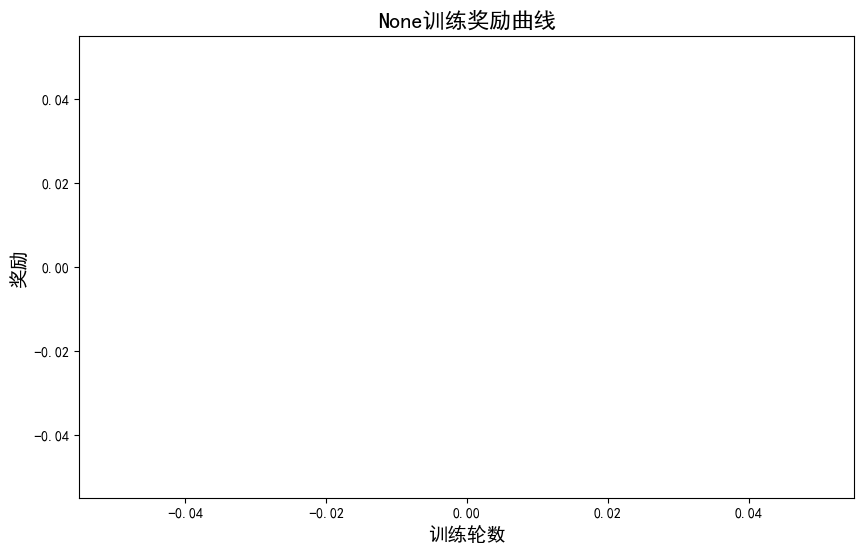

In [ ]:
plot_data(plot_title=f"{agent.model_name}训练奖励曲线",
          xlabel="训练轮数",
          ylabel="奖励",
          data_sets=[episode_rewards],
          save_path=save_plot_path)
logging.info(f"奖励图表已保存: {save_plot_path}")

### 测试模型

仿真进度: 2501it [00:00, 13649.54it/s]                          
仿真进度: 2501it [00:03, 766.97it/s]                           


-1728765.6181728742


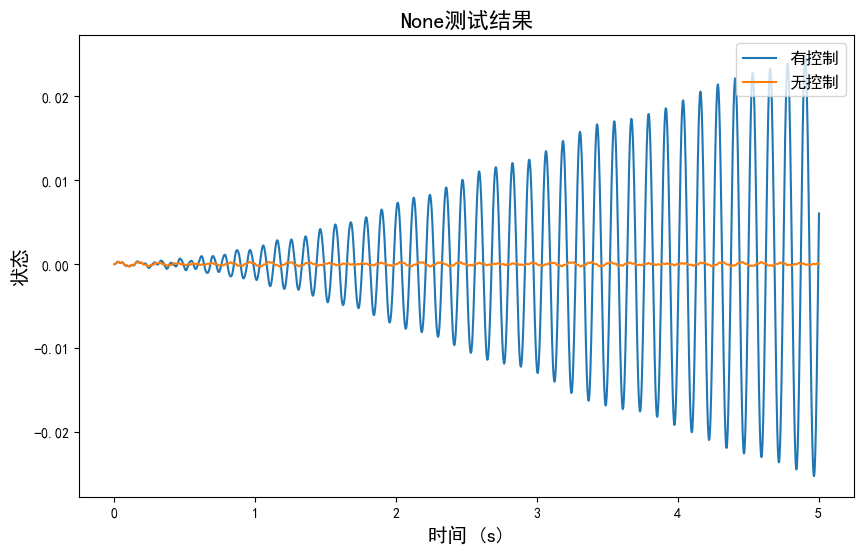

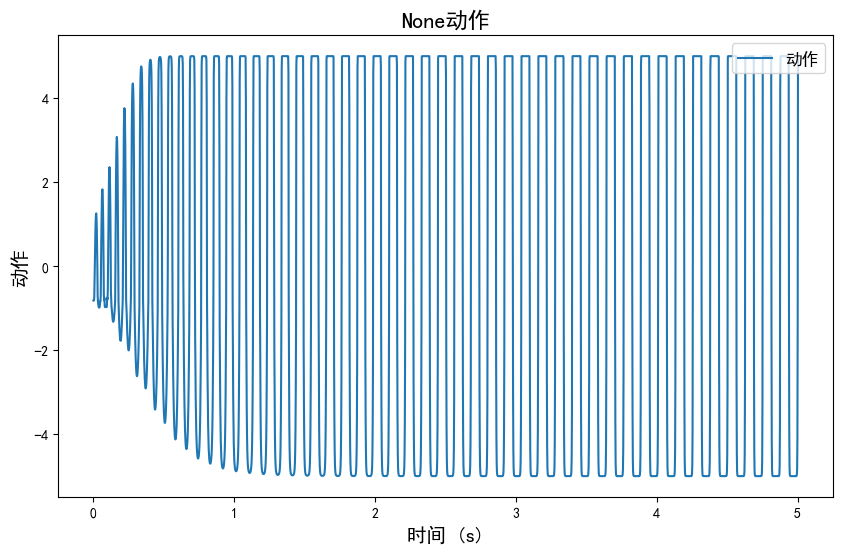

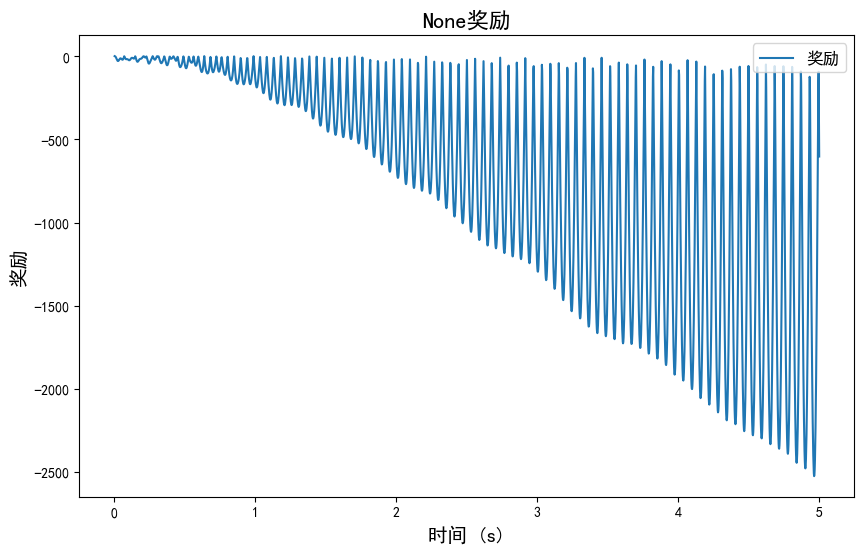

In [ ]:
# 运行测试
results_nc = rl_env.run_simulation(z_func=sine_disturbance(0.001, 30), r_func=r_func)
results_ddpg = rl_env.run_simulation(controller=agent, z_func=sine_disturbance(0.001, 30))
print(np.sum(results_ddpg['rewards']))

plot_data(plot_title=f"{agent.model_name}测试结果",
          xlabel="时间 (s)",
          ylabel="状态",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['all_states'][:, 3], results_nc['all_states'][:, 3]],
          save_path=save_plot_path,
          legends=["有控制", "无控制"]
          )

plot_data(plot_title=f"{agent.model_name}动作",
          xlabel="时间 (s)",
          ylabel="动作",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['actions']],
          save_path=save_plot_path,
          legends=["动作"]
          )

plot_data(plot_title=f"{agent.model_name}奖励",
          xlabel="时间 (s)",
          ylabel="奖励",
          x_values=results_ddpg['times'],
          data_sets=[results_ddpg['rewards']],
          save_path=save_plot_path,
          legends=["奖励"]
          )